In [49]:
import SimpleITK as sitk
import os
import tensorflow as tf
import pandas as pd
import time
import nibabel as nib

from matplotlib import pyplot as plt
from dltk.io.augmentation import *
from dltk.io.preprocessing import *

%matplotlib inline

In [3]:
class Timer(object):
    
    def __init__(self,name):
        self.name = name
    
    def __enter__(self):
        self.t = time.time()
    
    def __exit__(self, *args, **kwargs):
        print("{} took {} seconds".format(
        self.name, time.time() - self.t))

In [4]:
batch_size = 5
iterations = 100

reader_params = {'n_example': 1,
                'example_size': [128,224,224],
                'extract_examples': True}

reader_example_shapes = {'feautres': {'x': tf.float32},
                        'label': {'y' : tf.int32} }

reader_example_dtypes = {'features': {'x': tf.float32},
                        'labe;s': {'y': tf.int32}}

## Reading Data with DLTK

In [5]:
import SimpleITK as sitk
import os
from dltk.io.augmentation import *
from dltk.io.preprocessing import *
import tensorflow as tf


In [6]:
root = 'D:\segmentiation/'
ct_set = os.path.join(root,'ct_train_test/ct_train/')
mr_set = os.path.join(root,'mr_train_test/mr_train/')

name_list = []
filenames = os.listdir(ct_set)

for i in filenames:
    if i[:13] not in name_list:
        name_list.append(i[:13])
        
total_list = []
for i in name_list:
    temp_name = i
    temp_image = i+'_image.nii'
    temp_label = i+'_label.nii'
    total_list.append({'name' : temp_name,'image':temp_image,'label':temp_label})

* Reader Function을 이용해서 파일들을 읽어 온다
* read_fn(file_references, mode, params=None)
* file_refrences : 파일을 읽기 위한 array 같은 변수




In [59]:
## Making Read_fn

data_path = ct_set

def read_fn(file_reference, mode, params=None):
    
    
    ## file_refrences를 파일 path로 일단 생각하자
    
    for file_dict in file_reference:
        
        file_name = file_dict['name']
        file_image = file_dict['image']
        file_label = file_dict['label']
        
        
        ## 이미지 데이터를 로드하는 함수 인듯?
        temp_path =os.path.join(data_path,file_image)
        temp_file = os.listdir(temp_path)
        t1_fn = os.path.join(temp_path,temp_file[0])
        
        ## Read nii -> image
        sitk_t1 = sitk.ReadImage(t1_fn)
        t1 = sitk.GetArrayFromImage(sitk_t1)
        
        ## whitening , 평균 0, 표준편차 1로 만들자
        t1 = whitening(t1)
        
        # 4D Tensor with a dummy dimension for channels
        # ex (363, 512, 512) --> (362, 512, 512, 1)
        t1 = t1[...,np.newaxis]
        
        
        ## prdeict mode 일 때는 label이 없다! 따라서 label 없는 값을 yield!
        if mode == tf.estimator.ModeKeys.PREDICT:
            yield{'features': {'x': t1},
                 'metadata':{
                     'subject_id': subgject_id,
                     'sitk': sitk_t1
                 }}
            
            
        ## Labels:
        ## 이 친구들은 원핫 인코더로 안해주나!??!
        ## Label 재혁이 코드 넣기
        
                ## 이미지 데이터를 로드하는 함수 인듯?
        temp_path =os.path.join(data_path,file_label)
        temp_file = os.listdir(temp_path)
        lbl_path = os.path.join(temp_path,temp_file[0])
        
        
        lbl_path = os.path.join(data_path,file_label)
        lbl = sitk.GetArrayFromImage(sitk.ReadImage(Label)).astype(np.int32)
        
        lbl = whitening(lbl)
        lbl = lbl[..., np.newaxis]
        y = lbl
        
        if mode == tf.estimator.ModeKeys.TRAIN:
            
            # Insert augmentation here
            pass
        
#         if params['extract_examples']:
#             images = extract_random_example_array(
#                 t1,
#                 example_size=params['example_size'],
#                 n_examples=params['n_examples'])
            
#             # Loop the extracted image patches and yield
#             for e in range(params['n_examples']):
#                 yield {'features': {'x': images[e].astype(np.float32)},
#                        'labels': {'y': y.astype(np.int32)},
#                        'metadata': {
#                            'subject_id': subject_id,
#                            'sitk': sitk_t1}}
        
    
        ## Batch 1 이라고 할 때
#         else:
        yield {'features' : {'x': t1},
                'labels':{'y' : y}}
        

## Using a custom read_fn with TensorFlow

In [8]:

## 데이터 타입, 사이즈 와 같은 하이퍼파라미터를 선언해주자
reader_example_shapes = {'features': {'x': reader_params['example_size'] + [1,]},
                         'labels': {'y': []}}

reader_params = {'n_examples': 1,
                 'example_size': [256, 256, 256],
                 'extract_examples': True}

reader_example_dtypes = {'features': {'x': tf.float32},
                         'labels': {'y': tf.int32}}

reader_example_dtypes = {'features': {'x': tf.float32},
                        'labels': {'y': tf.int32}}

from dltk.io.abstract_reader import Reader
reader = Reader(read_fn=read_fn,
               dtypes=reader_example_dtypes)


In [9]:
# Now, get the input function and queue initialisation hook to use in a `tf.Session` or 
# with `tf.Estimator`. `shuffle_cache_size` defines the capacity of the queue.

# tf.Session 과 tf.Estimator를 사용하기 위해 input_fn과 quene initialisation을 사용하자

input_fn, qinit_hook = reader.get_inputs(total_list,
                                        tf.estimator.ModeKeys.TRAIN,
                                        example_shapes=reader_example_shapes,
                                        batch_size=1,
                                        shuffle_cache_size=1,
                                        params=reader_params)


features, labels = input_fn()

## Building a model Function

In [15]:

import SimpleITK as sitk
import tensorflow as tf
import os

from dltk.io.augmentation import *
from dltk.io.preprocessing import *

tf.logging.set_verbosity(tf.logging.ERROR)

# Generate a simple toy dataset
im_width = 256
im_height = 256
num_imgs = 200

def create_test_image(width, height, num_objs=12, rad_max=30):
    '''Return a noisy 2D image with `num_objs' circles and a 2D mask image.'''
    image = np.zeros((width, height))

    for i in range(num_objs):
        x = np.random.randint(rad_max, width - rad_max)
        y = np.random.randint(rad_max, height - rad_max)
        rad = np.random.randint(10, rad_max)
        
        spy, spx = np.ogrid[-x:width - x, -y:height - y]
        circle = (spx * spx + spy * spy) <= rad * rad
        image[circle] = np.random.random() * 0.5 + 0.5

    norm = np.random.uniform(0, 0.25, size=image.shape)

    return np.maximum(image, norm), (image > 0).astype(np.int32) 

# Note, that the read_fn does not rely on the `file_references` in this case and 
# just ignores it. Other than that, we create a similar `read_fn` as in 
# `dltk/examples/tutorials/01_Reading_data.ipynb`:
def read_fn(file_references, mode, params=None):
    
    im, mask = create_test_image(im_width,im_height)
    
    yield {'features': {'x': im[np.newaxis, :, :, np.newaxis]},
           'labels': {'y': mask[np.newaxis]}}

Building plotting  hooks for jupyter notebook

In [16]:
from matplotlib import pyplot as plt
from IPython import display

%matplotlib inline


class NotebookLoggingHook(tf.train.SessionRunHook):
    def __init__(self, fetches):
        self.fetches = fetches
        self.loss = []
        
    def before_run(self, run_context):
        # Add the tensors to fetch to the session
        return tf.train.SessionRunArgs(self.fetches)
    
    def after_run(self, run_context, run_values):
        # Extract the results of the fetched tensors
        fetch_dict = run_values.results
        
        # Assume to have {'loss': scalar, 'input': img, 'output': img, 'truth': img}
        self.loss.append(fetch_dict['loss'])
        
        # Plot stuff using `matplotlib`
        f, axarr = plt.subplots(2, 2, figsize=(16,8))
        axarr[0,0].imshow(np.squeeze(fetch_dict['x'][0,0,:,:,0]), cmap='gray')
        axarr[0,0].set_title('Input: x')
        axarr[0,0].axis('off')

        axarr[0,1].plot(self.loss)
        axarr[0,1].set_title('Crossentropy loss')
        axarr[0,1].set_yscale('log')
        axarr[0,1].axis('on')

        axarr[1,0].imshow(np.squeeze(fetch_dict['y_'][0,0,:,:]), cmap='gray', vmin=0, vmax=1)
        axarr[1,0].set_title('Prediction: y_')
        axarr[1,0].axis('off')

        axarr[1,1].imshow(np.squeeze(fetch_dict['y'][0,0,:,:]), cmap='gray', vmin=0, vmax=1)
        axarr[1,1].set_title('Truth: y')
        axarr[1,1].axis('off')

        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.close(f)

Building a model_fn

In [39]:
# Create a `NotebookLoggingHook`
nl_hook = NotebookLoggingHook(None)
hooks = [nl_hook]


## Model function 만들기 
# 인자 : Features, labels,mode, params
def model_fn(features, labels, mode, params):
    
     # 인풋을 넣으면 자동으로 트레인을 할 수 있도록 틀을 짜놓고
     # 모델은 바꾸면서 낄 수 있도록
#     residual_fcn_3d(inputs,
#                     num_classes,
#                     num_res_units=1,
#                     filters=(16, 32, 64, 128),
#                     strides=((1, 1, 1), (2, 2, 2), (2, 2, 2), (2, 2, 2)),
#                     mode=tf.estimator.ModeKeys.EVAL,
#                     use_bias=False,
#                     activation=tf.nn.relu6,
#                     kernel_initializer=tf.initializers.variance_scaling(distribution='uniform'),
#                     bias_initializer=tf.zeros_initializer(),
#                     kernel_regularizer=None,
#                     bias_regularizer=None)
    # 예시로 모델 하나 불러오기
    from dltk.networks.segmentation.fcn import residual_fcn_3d
    
    ### 왜 Strides 가 (1,2,2) 일까...
    ### Z 축으로 이동할 때는 한 칸씩 들어 간다는 뜻인가
    net_output_ops = residual_fcn_3d(features['x'], 2, num_res_units=1, filters=(16, 32, 64),
                                    strides=((1, 1, 1), (1, 2, 2),  (1, 2, 2)), mode = mode)
    
    if mode == tf.estimator.ModeKeys.PREDICT:
        return tf.estimator.EstimatorSpec(
            mode=mode,
            predictions=net_output_ops,
            export_outputs={'out':tf.estimator.export.PredictOutput(net_output_ops)})
    
    ## sparse soft max???
    loss = tf.losses.sparse_softmax_cross_entropy(labels['y'],
                                                 net_output_ops['logits'])
    ## global step ??
    global_step = tf.train.get_global_step()
    optimizer = tf.train.AdamOptimizer(learning_rate=params["learning_rate"],
                                      epsilon=1e-5)
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        train_op = optimizer.minimize(loss, global_step)
    
    ## 노트북에 플랏팅하기
    
    my_notebook_fetches = {}
    my_notebook_fetches['loss'] = loss
    my_notebook_fetches['x'] = features['x']
    my_notebook_fetches['y'] = labels['y']
    my_notebook_fetches['y_'] = net_output_ops['y_']
    nl_hook.fetches = my_notebook_fetches

    
    return tf.estimator.EstimatorSpec(mode=mode,
                                     predictions=net_output_ops,
                                     loss=loss,
                                     train_op=train_op,
                                     eval_metric_ops=None)
    
    

### input_fn + model_fn 해서 트레이닝 해보자!

In [40]:
from dltk.io.abstract_reader import Reader

# Set up a data reader to handle the file i/o. 
reader_example_shapes = {'features': {'x': [1, im_width, im_height, 1]},
                         'labels': {'y': [1, im_width, im_height]}}

reader = Reader(read_fn, {'features': {'x': tf.float32},
                          'labels': {'y': tf.int32}})

input_fn, qinit_hook = reader.get_inputs(file_references=None,
                                         mode=tf.estimator.ModeKeys.TRAIN,
                                         example_shapes=reader_example_shapes)

In [41]:
nn = tf.estimator.Estimator(model_fn=model_fn, 
                            model_dir=None, 
                            params={"learning_rate": 0.001})

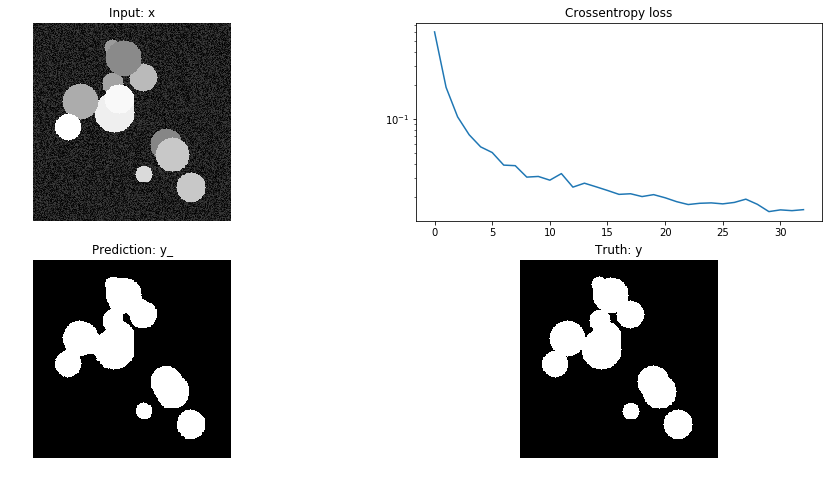

In [43]:
_ = nn.train(input_fn=input_fn, hooks=hooks + [qinit_hook], steps=30)

## DLTK Function Test

In [56]:
def nii_loader(path,file_name):
    file_path =  os.path.join(path,file_name)
    fn = os.listdir(file_path)
    image = (nib.load(file_path + '/' + fn[0]))
    return image


data_path = ct_set

file_dict = total_list[0]
file_name = file_dict['name']
file_image = file_dict['image']
file_label = file_dict['label']

## 이미지 데이터를 로드하는 함수 인듯?
temp_path =os.path.join(data_path,file_image)
temp_file = os.listdir(temp_path)
t1_fn = os.path.join(temp_path,temp_file[0])

## Read nii -> image
sitk_t1 = sitk.ReadImage(t1_fn)
t1 = sitk.GetArrayFromImage(sitk_t1)


n1 = nii_loader(data_path,file_image)
n1_array = n1.get_data()

In [55]:
file_image

'ct_train_1001_image.nii'

In [60]:
t1.shape

(363, 512, 512)

In [62]:
n1_array.shape

(512, 512, 363)

In [50]:
n1 = nii_loader(data_path,file_image)
n1_array = n1.get_data()

In [63]:
n1_array == t1

C:\Users\Nakyilkim\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: elementwise == comparison failed; this will raise an error in the future.
  """Entry point for launching an IPython kernel.


False

In [44]:
total_list

[{'name': 'ct_train_1001',
  'image': 'ct_train_1001_image.nii',
  'label': 'ct_train_1001_label.nii'},
 {'name': 'ct_train_1002',
  'image': 'ct_train_1002_image.nii',
  'label': 'ct_train_1002_label.nii'},
 {'name': 'ct_train_1003',
  'image': 'ct_train_1003_image.nii',
  'label': 'ct_train_1003_label.nii'},
 {'name': 'ct_train_1004',
  'image': 'ct_train_1004_image.nii',
  'label': 'ct_train_1004_label.nii'},
 {'name': 'ct_train_1005',
  'image': 'ct_train_1005_image.nii',
  'label': 'ct_train_1005_label.nii'},
 {'name': 'ct_train_1006',
  'image': 'ct_train_1006_image.nii',
  'label': 'ct_train_1006_label.nii'},
 {'name': 'ct_train_1007',
  'image': 'ct_train_1007_image.nii',
  'label': 'ct_train_1007_label.nii'},
 {'name': 'ct_train_1008',
  'image': 'ct_train_1008_image.nii',
  'label': 'ct_train_1008_label.nii'},
 {'name': 'ct_train_1009',
  'image': 'ct_train_1009_image.nii',
  'label': 'ct_train_1009_label.nii'},
 {'name': 'ct_train_1010',
  'image': 'ct_train_1010_image.nii',

### label Encoder 고치기

In [119]:
### Check 8 mr_file

root = 'D:\segmentiation/'
ct_set = os.path.join(root,'ct_train_test/ct_train/')
mr_set = os.path.join(root,'mr_train_test/mr_train/')
filenames_ct = os.listdir(ct_set)
filenames_mr = os.listdir(mr_set)


In [122]:
filepath = os.path.join(mr_set,filenames_mr[8])


In [123]:
filepath

'D:\\segmentiation/mr_train_test/mr_train/mr_train_1005_image.nii'

In [129]:
name_list = []
for i in filenames_mr:
    if i[:13] not in name_list:
        name_list.append(i[:13])
        
total_list = []
for i in name_list:
    temp_name = i
    temp_image = i+'_image.nii'
    temp_label = i+'_label.nii'
    total_list.append({'name' : temp_name,'image':temp_image,'label':temp_label})

In [133]:
filepath = os.path.join(mr_set,total_list[8]['label'])
lbl_fn = os.listdir(filepath)
lbl = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(filepath,lbl_fn[0])))


In [135]:
np.unique(lbl)

array([  0, 205, 420, 500, 550, 600, 820, 850], dtype=uint16)

In [136]:
filepath = os.path.join(mr_set,total_list[9]['label'])
lbl_fn = os.listdir(filepath)
lbl = sitk.GetArrayFromImage(sitk.ReadImage(os.path.join(filepath,lbl_fn[0])))
np.unique(lbl)

array([  0, 205, 420, 421, 500, 550, 600, 820, 850], dtype=uint16)

In [83]:
class_type = np.unique(lbl)

In [84]:
OHE = OneHotEncoder()

In [90]:
OHE.fit(class_type.reshape(-1,1))

OneHotEncoder(categorical_features='all', dtype=<class 'numpy.float64'>,
       handle_unknown='error', n_values='auto', sparse=True)

In [93]:
OHE.transform(class_type.reshape(-1,1)).toarray()

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.]])

In [101]:
OHE.transform(np.array([[109]])).toarray()

array([[0., 0., 1., 0., 0., 0., 0., 0.]])

### Padding 고치자

In [142]:
### Sample Data 만들어서
### Padding, Resize 해보자

sample_list = [int(i) for i in range(128*128*64)]

In [144]:
sample_np = np.array(sample_list).reshape(128,128,64)

In [150]:
def inspect(numpy):
    print(numpy.shape, numpy)

In [151]:
inspect(sample_np)

(128, 128, 64) [[[      0       1       2 ...      61      62      63]
  [     64      65      66 ...     125     126     127]
  [    128     129     130 ...     189     190     191]
  ...
  [   8000    8001    8002 ...    8061    8062    8063]
  [   8064    8065    8066 ...    8125    8126    8127]
  [   8128    8129    8130 ...    8189    8190    8191]]

 [[   8192    8193    8194 ...    8253    8254    8255]
  [   8256    8257    8258 ...    8317    8318    8319]
  [   8320    8321    8322 ...    8381    8382    8383]
  ...
  [  16192   16193   16194 ...   16253   16254   16255]
  [  16256   16257   16258 ...   16317   16318   16319]
  [  16320   16321   16322 ...   16381   16382   16383]]

 [[  16384   16385   16386 ...   16445   16446   16447]
  [  16448   16449   16450 ...   16509   16510   16511]
  [  16512   16513   16514 ...   16573   16574   16575]
  ...
  [  24384   24385   24386 ...   24445   24446   24447]
  [  24448   24449   24450 ...   24509   24510   24511]
  [  24512 

In [154]:
img = np.array([[1,2,3,4,5], [6,7,8,9,10]])
padding = 2
npad = ((2,2),(2,2))

In [157]:
img

array([[ 1,  2,  3,  4,  5],
       [ 6,  7,  8,  9, 10]])

In [ ]:
### img = np.array([[1,2,3,4,5], [6,7,8,9,10]])
padding = 2


## Axis 0 , Axis 1 순서 대로 인듯
## 만약 3차원이였으면 axis = 0 Z 축이 되겠지..
## 가장 안쪽만 Pad 해주고 나머지 0 ,0  해야 밑에 해보자
npad = ((2,2),(2,2))
img_padding = np.pad(img,npad, 'constant', constant_values=(0))
plt.imshow(img_padding, cmap ='gray')
plt.show()

### 3D padding

In [1]:
from mpl_toolkits import mplot3d

img = np.array([[[1,2,3], 
                [15,16,17],
                [18,19,20]]
               ]
              )


npad = ((1,1),(0,0),(0,0))
img_padding = np.pad(img,npad, 'constant', constant_values=(0))

fig = plt.figure()
ax = plt.axes(projection='3d')
ax.plot(img_padding)
# plt.imshow(img_padding, cmap ='gray')
# plt.show()

NameError: name 'np' is not defined

In [188]:
img[:,:,0]

array([[ 1,  4,  7],
       [12, 15, 18]])

In [189]:
img

array([[[ 1,  2,  3],
        [ 4,  5,  6],
        [ 7,  8,  9]],

       [[12, 13, 14],
        [15, 16, 17],
        [18, 19, 20]]])

In [173]:
img.

(2, 3, 3)

#### img_padding


In [17]:
img = np.array([[1,2,3,4,5], [6,7,8,9,10]])

array([[0.66666667, 1.        , 1.33333333],
       [0.66666667, 1.        , 1.33333333]])

In [18]:
np.mean(tmp_array2, axis = 2)

array([[0.66666667, 0.33333333, 2.        ],
       [0.66666667, 0.33333333, 2.        ]])